<a href="https://colab.research.google.com/github/khare19yash/Automated-Detection-of-Neuropsychiatric-Disorders/blob/master/Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd gdrive/My Drive/IIITH_Internship/Neuro/Final

/content/gdrive/My Drive/IIITH_Internship/Neuro/Final


In [ ]:
cd gdrive/My Drive/Final

In [3]:
#options: cc200, dosenbach160, aal
p_ROI = "cc200"
p_fold = 10
p_center = "Stanford"
p_mode = "whole"
p_augmentation = False
p_Method = "ASD-DiagNet"

In [4]:
parameter_list = [p_ROI,p_fold,p_center,p_mode,p_augmentation,p_Method]
print("*****List of patameters****")
print("ROI atlas: ",p_ROI)
print("per Center or whole: ",p_mode)
if p_mode == 'percenter':
    print("Center's name: ",p_center)
print("Method's name: ",p_Method)
if p_Method == "ASD-DiagNet":
    print("Augmentation: ",p_augmentation)


*****List of patameters****
ROI atlas:  cc200
per Center or whole:  whole
Method's name:  ASD-DiagNet
Augmentation:  False


In [5]:
!pip install pyprind

In [6]:
!pip install wandb

     |████████████████████████████████| 1.8 MB 10.0 MB/s 
     |████████████████████████████████| 170 kB 71.5 MB/s 
     |████████████████████████████████| 138 kB 70.8 MB/s 
     |████████████████████████████████| 133 kB 73.9 MB/s 
     |████████████████████████████████| 97 kB 8.4 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 62 kB 947 kB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=25d8adc8a375851f916802b64c373d2ad9b31493ee866034792f2e2b1f00c9db
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=06bae2f7c4760f01c69ff9e42aabd051ac6b4a696ca78066aaeb7afab6f0fba4
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools
  Attempting uninstall: urll

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import reduce
from sklearn.impute import SimpleImputer
import time
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import sys
import pickle
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import silhouette_samples, silhouette_score
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from scipy import stats
from sklearn import tree
from sklearn.cluster import MiniBatchKMeans
import functools
import numpy.ma as ma # for masked arrays
import pyprind
import random
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm

from itertools import groupby
import sklearn
import pyprind
import wandb
# !wandb login d164742a4a99e4e581f543102aff0992153ad225

## Importing the data 

In [8]:
def get_key(filename):
    f_split = filename.split('_')
    if f_split[3] == 'rois':
        key = '_'.join(f_split[0:3]) 
    else:
        key = '_'.join(f_split[0:2])
    return key

In [9]:
cc200_data_path = './data/filt_global/rois_cc200'#cc200'#path to time series data
data_df = pd.read_csv('./data/Phenotypic_V1_0b_preprocessed949.csv',encoding= 'unicode_escape')#path 
data_df.DX_GROUP = data_df.DX_GROUP.map({1: 1, 2:0})
data_df['FILE_PATH'] = data_df['FILE_ID'].apply(lambda x : os.path.join(cc200_data_path,x + '_rois_cc200.1D')) 

print('Length of data frame : ', len(data_df))
print('Sample file path : ', data_df['FILE_PATH'].values[0])
print(data_df.head())

Length of data frame :  949
Sample file path :  ./data/filt_global/rois_cc200/Pitt_0050003_rois_cc200.1D
   Unnamed: 0  ...                                          FILE_PATH
0           0  ...  ./data/filt_global/rois_cc200/Pitt_0050003_roi...
1           1  ...  ./data/filt_global/rois_cc200/Pitt_0050004_roi...
2           2  ...  ./data/filt_global/rois_cc200/Pitt_0050006_roi...
3           3  ...  ./data/filt_global/rois_cc200/Pitt_0050007_roi...
4           4  ...  ./data/filt_global/rois_cc200/Pitt_0050009_roi...

[5 rows x 107 columns]


### Helper functions for computing correlations

In [10]:
def get_label(filename):
    assert (filename in labels)
    return labels[filename]

def get_corr_data(df):
              
    with np.errstate(invalid="ignore"):
        corr = np.nan_to_num(np.corrcoef(df.T))
        mask = np.invert(np.tri(corr.shape[0], k=-1, dtype=bool))
        m = ma.masked_where(mask == 1, mask)
        return ma.masked_where(m, corr).compressed()
        
def get_corr_matrix(filename,data_path):
    # returns correlation matrix
    for file in os.listdir(data_path):
        if file.startswith(filename):
            df = pd.read_csv(os.path.join(data_path, file), sep='\t')
    with np.errstate(invalid="ignore"):
        corr = np.nan_to_num(np.corrcoef(df.T))
        return corr

def confusion(g_turth,predictions):
    tn, fp, fn, tp = confusion_matrix(g_turth,predictions).ravel()
    accuracy = (tp+tn)/(tp+fp+tn+fn)
    sensitivity = (tp)/(tp+fn)
    specificty = (tn)/(tn+fp)
    return accuracy,sensitivity,specificty

def get_regs(samplesnames,regnum):
    # returns region index array
    datas = []
    for sn in samplesnames:
        datas.append(all_corr[sn][0])
    datas = np.array(datas)     # datas shape len(samplesnames)x19900
    avg=[]
    for ie in range(datas.shape[1]):
        avg.append(np.mean(datas[:,ie]))
    avg=np.array(avg)
    highs=avg.argsort()[-regnum:][::-1]
    lows=avg.argsort()[:regnum][::-1]
    regions=np.concatenate((highs,lows),axis=0) # shape (9950,)
    return regions

In [13]:
labels = data_df['DX_GROUP'].values
fpaths = data_df['FILE_PATH'].values
flist = data_df['FILE_ID'].values

print("Unique values in labels : ", np.unique(labels, return_counts = True))

Unique values in labels :  (array([0, 1]), array([530, 419]))


In [ ]:
# all_corr = {}

# for i,path in enumerate(fpaths):
#     key = flist[i]
#     x = np.loadtxt(path)
#     x = np.array(x, dtype = 'float32')
#     x = get_corr_data(x)
#     all_corr[key] = (x,labels[i])
# print('Length of correlations vector : ', len(all_corr))
# pickle.dump(all_corr, open('./data/SFC_CC200.pkl', 'wb'))
# # pickle.dump(all_corr, open('./data/Timeseries_CC200.pkl', 'wb'))
# print('Length of correlation vector in all_corr : ', len(all_corr[flist[0]][0]))

In [14]:
all_corr = pickle.load(open('./data/SFC_CC200.pkl', 'rb'))
# all_corr = pickle.load(open('./data/Timeseries_CC200.pkl', 'rb'))

In [15]:
print(len(flist))
print(flist[ : 10])

949
['Pitt_0050003' 'Pitt_0050004' 'Pitt_0050006' 'Pitt_0050007'
 'Pitt_0050009' 'Pitt_0050010' 'Pitt_0050011' 'Pitt_0050013'
 'Pitt_0050014' 'Pitt_0050015']


In [ ]:
# sfc = []
# labels = []
# for i,f in enumerate(flist):
#     sfc.append(all_corr[f][0])
#     labels.append(all_corr[f][1])

# sfc = np.asarray(sfc)
# labels = np.asarray(labels)
# print('SFC Shape : ',sfc.shape)
# print('Labels Shape : ', labels.shape)

SFC Shape :  (949, 19900)
Labels Shape :  (949,)


In [16]:
np.unique(labels, return_counts=True)

(array([0, 1]), array([530, 419]))

In [18]:
print(len(all_corr))
print(all_corr[flist[0]][0].shape)

949
(19900,)


In [27]:
class ASDDataset(Dataset):
    def __init__(self, all_corr, samples):
        self.corr = all_corr
        self.samples = samples
        pass
    def __getitem__(self,idx):
        return torch.tensor(self.corr[self.samples[idx]][0],dtype=torch.float),torch.tensor(self.corr[self.samples[idx]][1],dtype=torch.float)
        pass
    def __len__(self):
        return len(self.samples)
        pass

# Defining Autoencoder class

In [20]:
class MTAutoEncoder(nn.Module):
    def __init__(self, num_inputs=990, 
                 num_latent=200, tied=True,
                 num_classes=2, use_dropout=False):
        super(MTAutoEncoder, self).__init__()
        
        self.num_latent = num_latent
        self.num_inputs = num_inputs
        
        self.fc_encoder = nn.Sequential (
                nn.Linear(self.num_inputs,4096),
                nn.Tanh(),
                nn.Linear(4096,1024),
                nn.Tanh())
        
        self.fc_decoder = nn.Sequential (
                nn.Linear(1024,4096),
                nn.Tanh(),
                nn.Linear(4096,self.num_inputs),
                nn.Tanh())
         
        self.sigmoid = nn.Sigmoid()
        if use_dropout:
            self.classifier = nn.Sequential (
                nn.Dropout(p=0.25),
                nn.Linear(1024, 1),
#                 nn.Sigmoid(),
#                 nn.Linear(128, 1),

            )
        else:
            self.classifier = nn.Sequential (
                nn.Linear(1024, 1),
#                 nn.Sigmoid(),
#                 nn.Linear(128, 1),
            )
            
         
    def forward(self, x, eval_classifier=True):

        x = self.fc_encoder(x)
        if eval_classifier:
            x_logit = self.classifier(x)   #   .squeeze(1)
            x_logit = self.sigmoid(x_logit)
            return x_logit 

        x = self.fc_decoder(x)        
        return x

model = MTAutoEncoder()

model

MTAutoEncoder(
  (fc_encoder): Sequential(
    (0): Linear(in_features=990, out_features=4096, bias=True)
    (1): Tanh()
    (2): Linear(in_features=4096, out_features=1024, bias=True)
    (3): Tanh()
  )
  (fc_decoder): Sequential(
    (0): Linear(in_features=1024, out_features=4096, bias=True)
    (1): Tanh()
    (2): Linear(in_features=4096, out_features=990, bias=True)
    (3): Tanh()
  )
  (sigmoid): Sigmoid()
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=1, bias=True)
  )
)

# Defining training and testing functions

In [21]:
def train(model, epoch, train_loader, p_bernoulli=None, mode='both', lam_factor=1.0):
    model.train()
    train_losses = []
    clf_train_loss = []
    ae_train_loss = []
    
    if mode == 'clf':
        final_targets = []
        final_predictions = []
    else:
        final_targets = None
        final_predictions = None    
    
    for i,(batch_x,batch_y) in enumerate(train_loader):
        if len(batch_x) != batch_size:
            continue
        if p_bernoulli is not None:
            if i == 0:
                p_tensor = torch.ones_like(batch_x).to(device)*p_bernoulli
            rand_bernoulli = torch.bernoulli(p_tensor).to(device)

        data, target = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()

        if mode == 'ae':
            if p_bernoulli is not None:
                rec_noisy = model(data*rand_bernoulli, False)
                loss_ae = criterion_ae(rec_noisy, data) / len(batch_x)
            else:
                rec = model(data, False)
                loss_ae = criterion_ae(rec, data) / len(batch_x)
                
            loss_total = loss_ae
            loss_ae_np = loss_ae.detach().cpu().numpy()
            
            clf_train_loss.append(0.0)
            ae_train_loss.append(loss_ae_np)
            train_losses.append([loss_ae_np, 0.0])
                
        if mode == 'clf':
            logits = model(data, True)
            logits = np.squeeze(logits, 1)
            loss_clf = criterion_clf(logits, target)

            proba = logits.detach().cpu().numpy()
            # proba = torch.sigmoid(logits).detach().cpu().numpy()
            predictions = np.ones_like(proba, dtype=np.int32)
            predictions[proba < 0.5] = 0
            
            final_targets.append(target.detach().cpu().numpy())
            final_predictions.append(predictions)
            
            loss_total = loss_clf
            loss_clf_np = loss_clf.detach().cpu().numpy()
            
            clf_train_loss.append(loss_clf_np)
            ae_train_loss.append(0.0)
            train_losses.append([0.0,loss_clf_np])
            

        loss_total.backward()
        optimizer.step()
    
    if (final_targets is not None) and (final_predictions is not None):
        final_targets = np.concatenate(final_targets)
        final_predictions = np.concatenate(final_predictions)
        train_accuracy = np.mean(final_targets == final_predictions)

        return np.mean(clf_train_loss), train_accuracy
    else:
        return np.mean(ae_train_loss), None

def validate(model, epoch, train_loader, mode='ae', lam_factor=1.0):
    model.eval()
    train_losses = []
    clf_train_loss = []
    ae_train_loss = []
    
    if mode == 'clf':
        final_targets = []
        final_predictions = []
    else:
        final_targets = None
        final_predictions = None    
    
    for i,(batch_x,batch_y) in enumerate(train_loader):
        if len(batch_x) != batch_size:
            continue
        data, target = batch_x.to(device), batch_y.to(device)

        if mode == 'ae':
            rec = model(data, False)
            loss_ae = criterion_ae(rec, data) / len(batch_x)
                
            loss_total = loss_ae
            loss_ae_np = loss_ae.detach().cpu().numpy()
            
            clf_train_loss.append(0.0)
            ae_train_loss.append(loss_ae_np)
            train_losses.append([loss_ae_np, 0.0])
                
        if mode == 'clf':
            logits = model(data, True)
            logits = np.squeeze(logits, 1)
            loss_clf = criterion_clf(logits, target)
            
            proba = logits.detach().cpu().numpy()
            # proba = torch.sigmoid(logits).detach().cpu().numpy()
            predictions = np.ones_like(proba, dtype=np.int32)
            predictions[proba < 0.5] = 0
            
            final_targets.append(target.detach().cpu().numpy())
            final_predictions.append(predictions)
            
            loss_total = loss_clf
            loss_clf_np = loss_clf.detach().cpu().numpy()
            
            clf_train_loss.append(loss_clf_np)
            ae_train_loss.append(0.0)
            train_losses.append([0.0,loss_clf_np])
    
    if (final_targets is not None) and (final_predictions is not None):
        final_targets = np.concatenate(final_targets)
        final_predictions = np.concatenate(final_predictions)
        train_accuracy = np.mean(final_targets == final_predictions)

        return np.mean(clf_train_loss), train_accuracy
    else:
        return np.mean(ae_train_loss), None


def test(model, criterion, test_loader, 
         eval_classifier=False, num_batch=None):
    test_loss, n_test, correct = 0.0, 0, 0
    eval_loss = []
    all_predss=[]
    if eval_classifier:
        y_true, y_pred = [], []
    with torch.no_grad():
        model.eval()
        for i,(batch_x,batch_y) in enumerate(test_loader):
            if num_batch is not None:
                if i >= num_batch:
                    continue
            data, target = batch_x.to(device), batch_y.to(device)
            logits = model(data, eval_classifier)
            logits = np.squeeze(logits, 1)
#             test_loss += criterion(rec, data).detach().cpu().numpy() 
#             n_test += len(batch_x)
            # target = np.squeeze(target, 1)
            test_loss = criterion(logits, target).detach().cpu().numpy() 
            eval_loss.append(test_loss)
            if eval_classifier:
                proba = logits.detach().cpu().numpy()
                # proba = torch.sigmoid(logits).detach().cpu().numpy()
                preds = np.ones_like(proba, dtype=np.int32)
                preds[proba < 0.5] = 0
                all_predss.extend(preds)###????
                y_arr = np.array(batch_y, dtype=np.int32)

                correct += np.sum(preds == y_arr)
                y_true.extend(y_arr.tolist())
                y_pred.extend(proba.tolist())
        mlp_acc,mlp_sens,mlp_spef = confusion(y_true,all_predss)
        metrics_dict = {'accuracy': np.round(mlp_acc, 4), 
                        'senstivity' : np.round(mlp_sens,4), 
                        'specificity' : np.round(mlp_spef,4), 
                        'loss' : np.round(np.mean(eval_loss),4)}
        
    return  metrics_dict

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [23]:
def attribute_image_features(algorithm, inputs):
    model.zero_grad()
    model.eval()
    tensor_attributions = algorithm.attribute(inputs = inputs, target = 0, return_convergence_delta=True)  
    return tensor_attributions

In [24]:
!pip install captum

     |████████████████████████████████| 1.4 MB 7.8 MB/s 


In [25]:
from sklearn.model_selection import train_test_split
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr import Saliency
import torchvision

In [ ]:
len(val_samples)

214

# ASD 2 Layer Model Training

In [28]:
if p_Method == "ASD-DiagNet" and p_mode == "whole":
    
    start = time.time()
    batch_size = 16
    learning_rate_ae, learning_rate_clf = 0.0001, 0.0001
    ae_epochs = 50     # 30
    clf_epochs = 50      # 50

    p_bernoulli = None
    augmentation = p_augmentation
    use_dropout = True

    start= time.time()

#     print('p_bernoulli: ', p_bernoulli)
#     print('augmentaiton: ', augmentation, 'aug_factor: ', aug_factor, 
#           'num_neighbs: ', num_neighbs, 'lim4sim: ', lim4sim)
#     print('use_dropout: ', use_dropout, '\n')
    
    # list to store metrics after each fold
    repeat_acc=[]
    repeat_sen=[]
    repeat_spec=[]
    repeat_loss=[]
    
    
    for rp in range(1):
        kf = StratifiedKFold(n_splits=p_fold, random_state=1, shuffle=True)
    # list to store metrics after each fold
        crossval_acc=[]
        crossval_sen=[]
        crossval_spec=[]
        crossval_loss=[]
        attributions = []
        best_fold_val_samples = []
        best_fold_weights = None
        for kk,(train_index, test_index) in enumerate(kf.split(flist, labels)):
            
            # NAME = f'asd-diagnet-fold-{kk+1}-rp-2'
            # ID = f'fold-{kk+1}-rp-2.1'
        
            train_samples, test_samples = flist[train_index],flist[test_index]
            train_labels = labels[train_index]
            
            train_samples, val_samples, train_labels, val_labels = train_test_split(train_samples, train_labels, test_size = 0.25,
                                                              random_state = 42, stratify = train_labels)
            
            print('Number of train samples : ', len(train_samples))
            print('Number of val samples : ', len(val_samples))
            print('Number of test samples : ', len(test_samples))

            verbose = (True if (kk == 0) else False)

            num_inpp = 19900
            n_lat = 512
            
            train_dataset = ASDDataset(all_corr, train_samples)
            val_dataset = ASDDataset(all_corr, val_samples)
            test_dataset = ASDDataset(all_corr, test_samples)
            
            train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
            val_dataloader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False)
            test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)
            
               

            model = MTAutoEncoder(tied = False, num_inputs = num_inpp, num_latent = n_lat, use_dropout = use_dropout)
            model = model.to(device)

            criterion_ae = nn.MSELoss(reduction='sum')
            criterion_clf = nn.BCELoss()               
            optimizer = optim.Adam(model.parameters(),lr = 0.0001, weight_decay = 0.05)          



            best_ae_model = None
            best_ae_loss = sys.float_info.max
            count = 0
            
            print("AE Training Started-----------")
            
            for epoch in range(1, ae_epochs+1):
                ae_train_loss,_ = train(model, epoch, train_dataloader, p_bernoulli, mode='ae')
                print(f'Epoch {epoch}/{ae_epochs}')
                train_content = f'AE Train loss: {(ae_train_loss):.4f}'

                ae_val_loss,_ = validate(model, epoch, val_dataloader, mode='ae')
                val_content = f'AE Val loss: {(ae_val_loss):.4f}'
                print(train_content)
                print(val_content)

                if(count == 5):
                    break

                if(ae_val_loss < best_ae_loss):
                    best_ae_model = model
                    best_ae_loss = ae_val_loss
                    count = 1
                else:
                    count = count + 1
                    
            
            print("CLF Training Started-----------")
            best_clf_model = None
            best_clf_acc = 0.0
            count = 0
            model = best_ae_model
            for epoch in range(1, clf_epochs+1):
                clf_train_loss, train_acc = train(model, epoch, train_dataloader, p_bernoulli, mode='clf')
                train_content = f'CLF Train loss: {(clf_train_loss):.4f}, Train Accuracy: {(train_acc):.4f}'

                clf_val_loss,val_acc = validate(model, epoch, val_dataloader, mode='clf')
                val_content = f'CLF Val loss: {(clf_val_loss):.4f}, Validation Accuracy: {(val_acc):.4f}'

                print(f'Epoch {epoch}/{clf_epochs}')
                print(train_content)
                print(val_content)

                if(count == 10):
                    break

                if(val_acc > best_clf_acc):
                    best_clf_model = model
                    best_clf_acc = val_acc
                    count = 1
                else:
                    count = count + 1
        

            metrics_dict = test(best_clf_model, criterion_clf, test_dataloader, eval_classifier=True)
            print("-----------------------------")
            print(f'Fold {kk+1}/{p_fold}')
            content = f'{metrics_dict}'
            print(content)
            print("-----------------------------")
            
            crossval_acc.append(metrics_dict['accuracy'])
            crossval_sen.append(metrics_dict['senstivity'])
            crossval_spec.append(metrics_dict['specificity'])
            crossval_loss.append(metrics_dict['loss'])

            if(max(crossval_acc) == metrics_dict['accuracy']) :
                best_fold_val_samples = val_samples
                best_fold_weights = best_clf_model.state_dict()
                best_fold_val_samples = np.array(best_fold_val_samples)
                np.save('./Visualization/Best_Fold_Val_Samples.npy', best_fold_val_samples)
                torch.save(best_clf_model.state_dict(), f'./Visualization/Best_Fold_Weights.pth')
                      

            
            #save the model after each fold
            
            # recorder = {'optimizer': optimizer.state_dict(),
            # 'model': model.state_dict(),
            # 'fold' : kk+1,
            # 'repitition' : rp+1}

            # torch.save(recorder, f'{NAME}.pt')
            
        print("*********************************")    
        print(f'Average Value after 10 Folds and repeats one {rp+1}------->')
        content = f'Accuracy: {np.round(np.mean(crossval_acc),4)}, Senstivity: {np.round(np.mean(crossval_sen),4)}, Specificity: {np.round(np.mean(crossval_spec),4)}, Loss: {np.round(np.mean(crossval_loss),4)}'
        print(content)
        print("*********************************") 
        
        repeat_acc.append(np.mean(crossval_acc))
        repeat_sen.append(np.mean(crossval_sen))
        repeat_spec.append(np.mean(crossval_spec))
        repeat_loss.append(np.mean(crossval_loss))

        attributions = np.array(attributions)
    
    print(f"Average Value after 1 Repeat:")
    content = f'Accuracy: {np.round(np.mean(repeat_acc),4)}, Senstivity: {np.round(np.mean(repeat_sen),4)}, Specificity: {np.round(np.mean(repeat_spec),4)}, Loss: {np.round(np.mean(repeat_loss),4)}'
    print(content)
        
    finish= time.time()
    print(finish-start)




Number of train samples :  640
Number of val samples :  214
Number of test samples :  95
AE Training Started-----------
Epoch 1/50
AE Train loss: 778.0757
AE Val loss: 683.2441
Epoch 2/50
AE Train loss: 633.3138
AE Val loss: 627.9912
Epoch 3/50
AE Train loss: 558.7278
AE Val loss: 593.8788
Epoch 4/50
AE Train loss: 503.8748
AE Val loss: 578.3251
Epoch 5/50
AE Train loss: 455.6268
AE Val loss: 555.6616
Epoch 6/50
AE Train loss: 412.4742
AE Val loss: 541.7264
Epoch 7/50
AE Train loss: 376.4464
AE Val loss: 537.5723
Epoch 8/50
AE Train loss: 344.7002
AE Val loss: 524.0412
Epoch 9/50
AE Train loss: 314.5940
AE Val loss: 520.0790
Epoch 10/50
AE Train loss: 288.7501
AE Val loss: 511.5185
Epoch 11/50
AE Train loss: 265.2958
AE Val loss: 505.8721
Epoch 12/50
AE Train loss: 242.5514
AE Val loss: 502.6372
Epoch 13/50
AE Train loss: 224.4874
AE Val loss: 502.1778
Epoch 14/50
AE Train loss: 208.1373
AE Val loss: 495.2220
Epoch 15/50
AE Train loss: 194.7257
AE Val loss: 492.5378
Epoch 16/50
AE Trai

In [29]:
best_fold_model = MTAutoEncoder(tied = False, num_inputs = num_inpp, num_latent = n_lat, use_dropout = use_dropout)
best_fold_model.load_state_dict(best_fold_weights)
best_fold_model = best_fold_model.to('cpu')
# best_fold_model = best_fold_model.to(device)

In [45]:
x_val, y_val = [], []
for f in best_fold_val_samples :
    x_val.append(all_corr[f][0])
    y_val.append(all_corr[f][1])

x_val = torch.tensor(x_val, dtype=torch.float)
y_val = np.array(y_val, dtype='float32')

In [76]:
probs = best_fold_model(x_val)
probs = probs.detach().cpu().numpy()
preds = np.round(probs)
probs = np.squeeze(probs, 1)
preds = np.squeeze(preds, 1)

In [77]:
preds = np.round(probs)
preds

array([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0.,
       1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 1., 1., 0., 0., 1.], dtype=float32)

In [78]:
print(probs.shape)
print(preds.shape)
print(y_val.shape)

(214,)
(214,)
(214,)


In [79]:
acc = np.mean(y_val == preds)
print('Accuracy : ', acc)

Accuracy :  0.719626168224299


In [80]:
df = {'Caseids' : best_fold_val_samples, 'Targets' : y_val, 'Predictions' : preds, 'Probabilities' : probs}
df = pd.DataFrame(df, columns = ['Caseids', 'Targets', 'Predictions', 'Probabilities'])
df.to_csv('./Visualization/Vis.csv')
df.head(15)

,Caseids,Targets,Predictions,Probabilities
0,OHSU_0050171,1.0,0.0,0.306376
1,CMU_b_0050667,0.0,0.0,0.103380
2,UM_1_0050307,1.0,0.0,0.400762
3,NYU_0050981,0.0,0.0,0.127785
4,USM_0050439,1.0,1.0,0.811906
5,NYU_0051054,0.0,0.0,0.162538
6,NYU_0051069,0.0,1.0,0.606833
7,UM_1_0050299,1.0,0.0,0.304586
8,UM_1_0050379,0.0,0.0,0.438429
9,NYU_0051019,0.0,0.0,0.055355


In [ ]:
# asd_index = np.where(y_val == 1)
# hc_index = np.where(y_val == 0)
# x_asd, y_asd, prob_asd, pred_asd = x_val[asd_index], y_val[asd_index], probs[asd_index], preds[asd_index]
# x_hc, y_hc, prob_hc, pred_hc = x_val[hc_index], y_val[hc_index], probs[hc_index], preds[hc_index]

In [82]:
df_asd = df[df['Targets'] == 1]
df_hc = df[df['Targets'] == 0]

print('Number of ASD Samples : ', len(df_asd))
print('Number of HC Samples : ', len(df_hc))

Number of ASD Samples :  97
Number of HC Samples :  117


In [83]:
df_hc

,Caseids,Targets,Predictions,Probabilities
1,CMU_b_0050667,0.0,0.0,0.103380
3,NYU_0050981,0.0,0.0,0.127785
5,NYU_0051054,0.0,0.0,0.162538
6,NYU_0051069,0.0,1.0,0.606833
8,UM_1_0050379,0.0,0.0,0.438429
...,...,...,...,...
204,Leuven_1_0050706,0.0,1.0,0.844226
208,KKI_0050775,0.0,0.0,0.392256
209,USM_0050445,0.0,1.0,0.873393
211,MaxMun_b_0051325,0.0,0.0,0.491044


In [84]:
df_hc_right = df_hc[df_hc['Predictions'] == 0]
print('Length of correctly prediction HC Samples : ', len(df_hc_right))
df_hc_right.head(15)

Length of correctly prediction HC Samples :  97


,Caseids,Targets,Predictions,Probabilities
1,CMU_b_0050667,0.0,0.0,0.103380
3,NYU_0050981,0.0,0.0,0.127785
5,NYU_0051054,0.0,0.0,0.162538
8,UM_1_0050379,0.0,0.0,0.438429
9,NYU_0051019,0.0,0.0,0.055355
10,NYU_0051124,0.0,0.0,0.238721
14,SBL_0051563,0.0,0.0,0.040370
20,Pitt_0050052,0.0,0.0,0.069996
21,USM_0050532,0.0,0.0,0.186708
25,Caltech_0051459,0.0,0.0,0.233598


In [85]:
df_asd_right = df_asd[df_asd['Predictions'] == 1]
print('Length of correctly prediction ASD Samples : ', len(df_asd_right))
df_asd_right.head(15)

Length of correctly prediction ASD Samples :  57


,Caseids,Targets,Predictions,Probabilities
4,USM_0050439,1.0,1.0,0.811906
13,UM_1_0050353,1.0,1.0,0.796338
16,UM_1_0050305,1.0,1.0,0.994593
18,UCLA_1_0051258,1.0,1.0,0.689850
19,CMU_a_0050646,1.0,1.0,0.788661
22,UM_1_0050301,1.0,1.0,0.597305
23,UCLA_1_0051204,1.0,1.0,0.768830
24,NYU_0050964,1.0,1.0,0.911509
34,Pitt_0050044,1.0,1.0,0.580280
38,UCLA_1_0051253,1.0,1.0,0.856459


In [86]:
df_asd_right_top = df_asd_right[df_asd_right['Probabilities'] > 0.8]
df_hc_right_top = df_hc_right[df_hc_right['Probabilities'] < 0.2]

print('Number of top ASD samples : ', len(df_asd_right_top))
print('Number of top HC samples : ', len(df_hc_right_top))

Number of top ASD samples :  30
Number of top HC samples :  61


In [88]:
x_asd_samples = df_asd_right_top['Caseids']
x_hc_samples = df_hc_right_top['Caseids']

In [94]:
x_asd_ig, y_asd_ig = [], []
for sample in x_asd_samples : 
    x_asd_ig.append(all_corr[sample][0])
    y_asd_ig.append(all_corr[sample][1])

x_asd_ig = torch.tensor(x_asd_ig, dtype=torch.float)
y_asd_ig = torch.tensor(y_asd_ig, dtype=torch.float)

In [95]:
x_hc_ig, y_hc_ig = [], []
for sample in x_hc_samples : 
    x_hc_ig.append(all_corr[sample][0])
    y_hc_ig.append(all_corr[sample][1])

x_hc_ig = torch.tensor(x_hc_ig, dtype=torch.float)
y_hc_ig = torch.tensor(y_hc_ig, dtype=torch.float)

In [96]:
print('Lenghts : ')
print(len(x_asd_ig))
print(len(x_hc_ig))

Lenghts : 
30
61


In [97]:
# best_fold_model = best_fold_model.to('cpu')
# x_test = torch.tensor(x_test, dtype=torch.float)

ig_asd = IntegratedGradients(best_fold_model)        
grads_asd, delta_asd = attribute_image_features(ig_asd, inputs = x_asd_ig)         

# saliency_asd = Saliency(best_fold_model)
# grads_asd = saliency_asd.attribute(inputs = x_asd_ig, target = 0)
# grads_asd = grads_asd.squeeze().cpu().detach().numpy()
# grads_asd = attr_ig_asd + grads_asd
# grads_asd = attr_ig_asd
grads_asd = torch.mean(grads_asd, axis = 0)
grads_asd = np.array(grads_asd)
print(f'Attributions of Fold {kk + 1} : ', grads_asd.shape)
# attributions.append(grads_asd) 

Attributions of Fold 10 :  (19900,)


In [98]:
# best_fold_model = best_fold_model.to('cpu')
# x_test = torch.tensor(x_test, dtype=torch.float)

ig_hc = IntegratedGradients(best_fold_model)        
grads_hc, delta_hc = attribute_image_features(ig_hc, inputs = x_hc_ig)         

# saliency_hc = Saliency(best_fold_model)
# grads_hc = saliency_hc.attribute(inputs = x_hc_ig, target = 0)
# grads_hc = grads_hc.squeeze().cpu().detach().numpy()
# grads_hc = attr_ig_hc + grads_hc
# grads_hc = attr_ig_hc
grads_hc= torch.mean(grads_hc, axis = 0)
grads_hc = np.array(grads_hc)
print(f'Attributions of Best Fold : ', grads_hc.shape)
# attributions.append(grads_asd) 

Attributions of Best Fold :  (19900,)


In [99]:
np.save('./Visualization/Attributions_ASD.npy', grads_asd)
np.save('./Visualization/Attributions_HC.npy', grads_hc)

In [100]:
print(np.max(grads_asd), np.min(grads_asd))
print(np.max(grads_hc), np.min(grads_hc))

0.0022270672538877417 -0.001607660601168136
0.0018908362994820575 -0.0020417672413045903


In [ ]:
def imshow(img):
    plt.imshow(np.transpose(img))
    plt.show()

### ROIS responsible in ASD

Number of unique elements in corr_matrix :  (array([0., 1.]), array([39801,   199]))
Most repeated ROIS in ASD :  [ 64  12  45 125  14  93  27  54  58 105 106  16  56  70  20  48  31  29
  52  63]
Number of times ROIS repeated in ASD :  [ 3.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.  4.  4.  5.  5.  5.  5.  5.
  7. 14.]


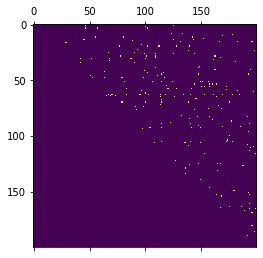

In [108]:
attr_vals_asd = grads_asd.copy()
# attr_vals_asd = np.where(attr_vals_asd > 0, 1  , 0)
# attr_vals_asd = (attr_vals_asd - np.min(attr_vals_asd)) / (np.max(attr_vals_asd) - np.min(attr_vals_asd))
# attr_vals_asd = attr_vals_asd / np.max(attr_vals_asd)
thresh = np.percentile(attr_vals_asd, 99)
attr_vals_asd = np.where(attr_vals_asd > thresh,  1 , 0)
corr_matrix_asd = np.zeros((200,200))
corr_matrix_asd[np.triu_indices(200, 1)] = attr_vals_asd
print('Number of unique elements in corr_matrix : ', np.unique(corr_matrix_asd, return_counts=True))
max_sum_rows_asd = np.sum(corr_matrix_asd, axis = 1)
max_indices_sort_asd = np.argsort(max_sum_rows_asd)
max_20_indices_asd = max_indices_sort_asd[-20 : ]
print('Most repeated ROIS in ASD : ', max_20_indices_asd)
max_val_sort_asd = np.sort(max_sum_rows_asd)
max_20_values_asd = max_val_sort_asd[-20 : ]
print('Number of times ROIS repeated in ASD : ', max_20_values_asd)
plt.matshow(corr_matrix_asd)

### ROIS responsible in HC

Number of unique elements in corr_matrix :  (array([0., 1.]), array([39801,   199]))
Most repeated ROIS in HC :  [125  85  83  35 153  20  12 105 127  27  58  56   3  31  48 106  54  29
  16  63]
Number of times ROIS repeated in HC :  [3. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4. 4. 5. 5. 5. 5. 6. 7. 7. 8.]


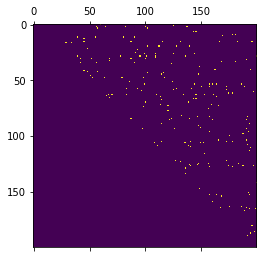

In [109]:
attr_vals_hc = grads_hc.copy()
# attr_vals_hc = np.where(attr_vals_hc > 0, 1  , 0)
# attr_vals_hc = (attr_vals_hc - np.min(attr_vals_hc)) / (np.max(attr_vals_hc) - np.min(attr_vals_hc))
# attr_vals_hc = attr_vals_hc / np.max(attr_vals_hc)
thresh = np.percentile(attr_vals_hc, 99)
attr_vals_hc = np.where(attr_vals_hc > thresh,  1 , 0)
corr_matrix_hc = np.zeros((200,200))
corr_matrix_hc[np.triu_indices(200, 1)] = attr_vals_hc
print('Number of unique elements in corr_matrix : ', np.unique(corr_matrix_hc, return_counts=True))
max_sum_rows_hc = np.sum(corr_matrix_hc, axis = 1)
max_indices_sort_hc = np.argsort(max_sum_rows_hc)
max_20_indices_hc = max_indices_sort_hc[-20 : ]
print('Most repeated ROIS in HC : ', max_20_indices_hc)
max_val_sort_hc = np.sort(max_sum_rows_hc)
max_20_values_hc = max_val_sort_hc[-20 : ]
print('Number of times ROIS repeated in HC : ',max_20_values_hc)
plt.matshow(corr_matrix_hc)

ASD ROIS Importance in incresing order \
64  12  45 125  14  93  27  54  58 105 106  16  56  70  20  48  31  29  52  63

HC ROIS Importance in incresing order \
125  85  83  35 153  20  12 105 127  27  58  56   3  31  48 106  54  29  16  63

In [120]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [121]:
cc200_labels = pd.read_csv('./Visualization/CC200_ROI_labels.csv')
cc200_labels.head(5)

,ROI number,volume,center of mass,Dosenbach,AAL,Eickhoff-Zilles,Talairach-Tournoux,Harvard-Oxford
0,1,162,(-39.6;-85.4;1.4),"[""None"": 0.91]","[""Occipital_Mid_L"": 0.81][""Occipital_Inf_L"": 0.19]","[""Left Middle Occipital Gyrus"": 0.70][""Left Inferior Occipital Gyrus"": 0.22]","[""Left Middle Occipital Gyrus"": 0.69][""Left Inferior Occipital Gyrus"": 0.31]","[""Left Lateral Occipital Cortex; inferior division"": 0.87]"
1,2,269,(-49.7;-60.8;23.2),"[""None"": 0.94]","[""Angular_L"": 0.49][""Temporal_Mid_L"": 0.45]","[""Left Middle Temporal Gyrus"": 0.69][""Left Angular Gyrus"": 0.22]","[""Left Middle Temporal Gyrus"": 0.57][""Left Superior Temporal Gyrus"": 0.32]","[""Left Angular Gyrus"": 0.46][""Left Lateral Occipital Cortex; superior division"": 0.39]"
2,3,284,(13.3;-64.4;24.0),"[""None"": 0.93]","[""Precuneus_R"": 0.47][""Cuneus_R"": 0.31][""Calcarine_R"": 0.22]","[""Right Calcarine Gyrus"": 0.38][""Right Precuneus"": 0.32][""Right Cuneus"": 0.24]","[""Right Precuneus"": 0.56][""Right Posterior Cingulate"": 0.27][""Right Cuneus"": 0.13]","[""Right Precuneous Cortex"": 0.65][""Right Cuneal Cortex"": 0.18]"
3,4,243,(-36.6;-13.9;-2.3),"[""None"": 0.92]","[""Temporal_Sup_L"": 0.33][""Putamen_L"": 0.28][""Insula_L"": 0.25]","[""Left Superior Temporal Gyrus"": 0.39][""Left Insula Lobe"": 0.23][""Left Putamen"": 0.20]","[""Left Insula"": 0.29][""Left Lentiform Nucleus"": 0.23][""Left Superior Temporal Gyrus"": 0.13][""Left Claustrum"": 0.12][""None"": 0.11]","[""Left Putamen"": 0.33][""Left Insular Cortex"": 0.30][""Left Planum Polare"": 0.21][""Left Heschl's Gyrus (includes H1 and H2)"": 0.11]"
4,5,222,(-6.8;45.7;7.8),"[""None"": 0.86]","[""Cingulum_Ant_L"": 0.66][""Frontal_Sup_Medial_L"": 0.28]","[""Left Anterior Cingulate Cortex"": 0.59][""Left Superior Medial Gyrus"": 0.22][""Left Mid Orbital Gyrus"": 0.18]","[""Left Medial Frontal Gyrus"": 0.59][""Left Anterior Cingulate"": 0.41]","[""Left Paracingulate Gyrus"": 0.62][""Left Cingulate Gyrus; anterior division"": 0.20]"


In [122]:
print('ASD Associated Regions : ')
asd_rois = cc200_labels[cc200_labels['ROI number'].isin(max_20_indices_asd[-5 : ])]
display(asd_rois[['ROI number', 'Harvard-Oxford']])

ASD Associated Regions : 


,ROI number,Harvard-Oxford
28,29,"[""Right Cingulate Gyrus; posterior division"": 0.52][""Right Cingulate Gyrus; anterior division"": 0.22][""Left Cingulate Gyrus; posterior division"": 0.17]"
30,31,"[""Right Superior Parietal Lobule"": 0.71][""Right Lateral Occipital Cortex; superior division"": 0.29]"
47,48,"[""Right Thalamus"": 0.31][""Right Hippocampus"": 0.29][""Right Parahippocampal Gyrus; posterior division"": 0.16][""Right Lingual Gyrus"": 0.13]"
51,52,"[""None"": 1.00]"
62,63,"[""Left Inferior Temporal Gyrus; temporooccipital part"": 0.42][""Left Temporal Occipital Fusiform Cortex"": 0.38][""Left Temporal Fusiform Cortex; posterior division"": 0.14]"


In [123]:
print('HC Associated Regions : ')
hc_rois = cc200_labels[cc200_labels['ROI number'].isin(max_20_indices_hc[-5 : ])]
print(hc_rois[['ROI number', 'Harvard-Oxford']])

HC Associated Regions : 
     ROI number  \
15   16           
28   29           
53   54           
62   63           
105  106          

                                                                                                                                                                Harvard-Oxford  
15   ["Left Lateral Occipital Cortex; inferior division": 0.72]["Left Inferior Temporal Gyrus; temporooccipital part": 0.15]                                                    
28   ["Right Cingulate Gyrus; posterior division": 0.52]["Right Cingulate Gyrus; anterior division": 0.22]["Left Cingulate Gyrus; posterior division": 0.17]                    
53   ["Left Cuneal Cortex": 0.30]["Right Cuneal Cortex": 0.25]["Left Occipital Pole": 0.22]["Left Lateral Occipital Cortex; superior division": 0.11]                           
62   ["Left Inferior Temporal Gyrus; temporooccipital part": 0.42]["Left Temporal Occipital Fusiform Cortex": 0.38]["Left Temporal Fusiform Cortex; post

# Saving the results 

In [ ]:
asd diagnet data augmentation with 1 neighbor
Accuracy: 0.7366, Senstivity: 0.6758, Specificity: 0.7849, Loss: 0.5751000046730042

Similarity function : dot product between correlation vectors(not the eigen vectors)  [nearest neighbor]
Accuracy: 0.744, Senstivity: 0.6778, Specificity: 0.7962, Loss: 0.557200014591217

Similarity function : dot product between correlation vectors(not the eigen vectors)  [random of 5 neighbors]
Accuracy: 0.7387, Senstivity: 0.6494, Specificity: 0.8094, Loss: 0.5447999835014343

asd diagnet data augmentation
Accuracy: 0.7608, Senstivity: 0.6971, Specificity: 0.8113, Loss: 0.5674999952316284

shuffling the sequence of timeseries with split number = 2 and aug_factor = 2
Accuracy: 0.7461, Senstivity: 0.68, Specificity: 0.7981, Loss: 0.5422999858856201

shuffling the sequence of timeseries with split number = 3 and aug_factor = 3
Accuracy: 0.7492, Senstivity: 0.6854, Specificity: 0.8, Loss: 0.5454000234603882

shuffling the sequence of timeseries with split number = 3 and aug_factor = 4
Accuracy: 0.7418, Senstivity: 0.666, Specificity: 0.8019, Loss: 0.5636000037193298

In [ ]:
Accuracy: 0.6724, Senstivity: 0.61, Specificity: 0.7321, Loss: 0.6234999895095825
589.3430550098419

In [ ]:
adam with weight decay 0.3 

Accuracy: 0.657, Senstivity: 0.5431, Specificity: 0.766, Loss: 0.6509000062942505
1160.326141834259


adam w/o weight decay 
Accuracy: 0.7043, Senstivity: 0.6636, Specificity: 0.7434, Loss: 0.5964999794960022
1056.0533220767975


adam with weight decay 0.1 
Average Value after 1 Repeat:
Accuracy: 0.7063, Senstivity: 0.6716, Specificity: 0.7396, Loss: 0.5821999907493591
1162.2546133995056

adam with weight decay 0.15 
Accuracy: 0.686, Senstivity: 0.6598, Specificity: 0.7113, Loss: 0.5911999940872192
1161.7236032485962

adam with weight decay 0.1  and dropout 0.25
Accuracy: 0.6985, Senstivity: 0.6793, Specificity: 0.717, Loss: 0.5842000246047974
1162.4763264656067


adam with weight decay 0.1  and dropout 0.25 n_lat 256
Average Value after 1 Repeat:
Accuracy: 0.6908, Senstivity: 0.6933, Specificity: 0.6887, Loss: 0.5952000021934509
1149.6250448226929

In [ ]:
AIMAFE Data


adam with weight decay 0.1  and dropout 0.25 n_lat 256
Average Value after 1 Repeat:
Accuracy: 0.7397, Senstivity: 0.6706, Specificity: 0.7944, Loss: 0.5264000296592712
1056.9974591732025


adam with weight decay 0.1  and dropout 0.25 n_lat 512
Average Value after 1 Repeat:
Accuracy: 0.7471, Senstivity: 0.6923, Specificity: 0.7906, Loss: 0.5105000138282776
1067.9337112903595

adam with weight decay 0.2  and dropout 0.25 n_lat 512
Average Value after 1 Repeat:
Accuracy: 0.7324, Senstivity: 0.6256, Specificity: 0.817, Loss: 0.5450999736785889
1068.7675378322601